In [11]:
import random
import numpy as np
import pandas as pd
class MinesweeperEnv(object):
    def __init__(self, width, height, n_mines,
        # based on https://github.com/jakejhansen/minesweeper_solver
        #rewards={'win':1, 'lose':-1, 'progress':0.3, 'guess':-0.3, 'no_progress' : -0.3}):
        rewards={'win':1, 'lose':0, 'bomb':-0.5, 'progress':0.3, 'guess':-0.3, 'no_progress' : -0.3}):
        self.nrows, self.ncols = width, height
        self.ntiles = self.nrows * self.ncols
        self.n_mines = n_mines
        self.grid = self.init_grid()
        self.board = self.get_board()
        self.state, self.state_im = self.init_state()
        self.n_clicks = 0
        self.n_progress = 0
        self.n_wins = 0

        self.rewards = rewards

    def init_grid(self):
        board = np.zeros((self.nrows, self.ncols), dtype='object')
        mines = self.n_mines

        while mines > 0:
            row, col = random.randint(0, self.nrows-1), random.randint(0, self.ncols-1)
            if board[row][col] != 'B':
                board[row][col] = 'B'
                mines -= 1

        return board

    def get_neighbors(self, coord):
        x,y = coord[0], coord[1]

        neighbors = []
        for col in range(y-1, y+2):
            for row in range(x-1, x+2):
                if ((x != row or y != col) and
                    (0 <= col < self.ncols) and
                    (0 <= row < self.nrows)):
                    neighbors.append(self.grid[row,col])

        return np.array(neighbors)

    def is_guess(self, state, coord):
        x,y = coord[0], coord[1]

        neighbors = []
        for col in range(y-1, y+2):
            for row in range(x-1, x+2):
                if ((x != row or y != col) and
                    (0 <= col < self.ncols) and
                    (0 <= row < self.nrows)):
                    neighbors.append(state[row, col])
        neighbors = np.array(neighbors)
        return all(t==-0.125 for t in neighbors)

    def count_bombs(self, coord):
        neighbors = self.get_neighbors(coord)
        return np.sum(neighbors=='B')

    def possibility_bombs(self, coord):
        neighbors = self.get_neighbors(coord)
        rand = np.random.random() # random value b/w 0 & 1
        if np.sum(neighbors=='B') == 0:
            if rand < 0.1: # possibility of mine
                ret = 1
            else:
                ret = 0
        else:
            ret = 1
        return ret

    def get_board(self):
        '''
        This board is revised.
        Number 1 means there is a mine around or more.
        Number 0 means there are no mines around.
        '''
        board = self.grid.copy()

        coords = []
        for x in range(self.nrows):
            for y in range(self.ncols):
                if self.grid[x,y] != 'B':
                    coords.append((x,y))

        for coord in coords:
            #board[coord] = self.count_bombs(coord)
            board[coord] = self.possibility_bombs(coord)

        return board

    def get_state_im(self, state):
        '''
        Gets the numeric image representation state of the board.
        This is what will be the input for the DQN.
        
        Meanings: 'U': Unknown i.e. not opened
                  'B': Mine
        '''

        state_im = [t['value'] for t in state]
        state_im = np.reshape(state_im, (self.nrows, self.ncols, 1)).astype(object)

        state_im[state_im=='U'] = -1
        state_im[state_im=='B'] = -2

        state_im = state_im.astype(np.int8) / 8
        state_im = state_im.astype(np.float16)

        return state_im

    def init_state(self):
        unsolved_array = np.full((self.nrows, self.ncols), 'U', dtype='object')

        state = []
        for (x, y), value in np.ndenumerate(unsolved_array):
            state.append({'coord': (x, y), 'value':value})

        state_im = self.get_state_im(state)

        return state, state_im

    def color_state(self, value):
        if value == -1:
            color = 'white'
        elif value == 0:
            color = 'slategrey'
        elif value == 1:
            color = 'blue'
        elif value == 2:
            color = 'green'
        elif value == 3:
            color = 'red'
        elif value == 4:
            color = 'midnightblue'
        elif value == 5:
            color = 'brown'
        elif value == 6:
            color = 'aquamarine'
        elif value == 7:
            color = 'black'
        elif value == 8:
            color = 'silver'
        else:
            color = 'magenta'

        return f'color: {color}'

    def draw_state(self, state_im):
        state = state_im * 8.0
        state_df = pd.DataFrame(state.reshape((self.nrows, self.ncols)), dtype=np.int8)

        display(state_df.style.applymap(self.color_state))

    def click(self, action_index):
        coord = self.state[action_index]['coord']
        value = self.board[coord]

        """
        # ensure first move is not a bomb
        if (value == 'B') and (self.n_clicks == 0):
            grid = self.grid.reshape(1, self.ntiles)
            move = np.random.choice(np.nonzero(grid!='B')[1])
            coord = self.state[move]['coord']
            value = self.board[coord]
            self.state[move]['value'] = value
        else:
            # make state equal to board at given coordinates
            self.state[action_index]['value'] = value
        """
        # make state equal to board at given coordinates
        self.state[action_index]['value'] = value

        """
        # reveal all neighbors if value is 0
        if value == 0.0:
            self.reveal_neighbors(coord, clicked_tiles=[])
        """

        self.n_clicks += 1

    def reveal_neighbors(self, coord, clicked_tiles):
        processed = clicked_tiles
        state_df = pd.DataFrame(self.state)
        x,y = coord[0], coord[1]

        neighbors = []
        for col in range(y-1, y+2):
            for row in range(x-1, x+2):
                if ((x != row or y != col) and
                    (0 <= col < self.ncols) and
                    (0 <= row < self.nrows) and
                    ((row, col) not in processed)):

                    # prevent redundancy for adjacent zeros
                    processed.append((row,col))

                    index = state_df.index[state_df['coord'] == (row,col)].tolist()[0]

                    self.state[index]['value'] = self.board[row, col]

                    # recursion in case neighbors are also 0
                    if self.board[row, col] == 0.0:
                        self.reveal_neighbors((row, col), clicked_tiles=processed)

    def reset(self):
        self.n_clicks = 0
        self.n_progress = 0
        self.grid = self.init_grid()
        self.board = self.get_board()
        self.state, self.state_im = self.init_state()

    def step(self, action_index):
        done = False
        coords = self.state[action_index]['coord']

        current_state = self.state_im

        # get neighbors before action
        is_guess_b = self.is_guess(current_state, coords)

        self.click(action_index)

        # update state image
        new_state_im = self.get_state_im(self.state)
        self.state_im = new_state_im

        board_flatten = self.board.flatten()
        unsolved_index = np.where(self.state_im.flatten() == -0.125)
        if np.array_equal(np.where(board_flatten == 'B'), 
                            unsolved_index): # if win
            #elif np.sum(new_state_im==-0.125) == self.n_mines: # if win
            reward = self.rewards['win']
            done = True
            self.n_progress += 1
            self.n_wins += 1
        
        elif (np.sum(self.state_im == -0.125) == 0) or \
                (np.sum(board_flatten[unsolved_index] != 'B') == 0): # if lose
            reward = self.rewards['lose']
            done = True

        # Does not lose if detect mine
        elif self.state[action_index]['value']=='B': # if find mines
            #reward = self.rewards['lose']
            reward = self.rewards['bomb']
            #done = True
        
        elif np.sum(self.state_im == -0.125) == np.sum(current_state == -0.125):
            reward = self.rewards['no_progress']

        else: # if progress
            if is_guess_b: # if guess (all neighbors are unsolved)
                reward = self.rewards['guess']

            else:
                reward = self.rewards['progress']
                self.n_progress += 1 # track n of non-isoloated clicks

        return self.state_im, reward, done

In [12]:
def stateConverter(OUT, state):
        """ Converts 2d state to one-hot encoded 3d state
            input: state (rows x cols)
            output: state3d (row x cols x 10) (if full)
                            (row x cols x 2) (if condensed)
                            (row x cols x 1) (if image)

        """
        rows, cols = state.shape
        if OUT == "FULL":
            res = np.zeros((rows,cols,10), dtype = int)
            for i in range(0,8):
                res[:,:,i] = state == i+1 #1-7
            res[:,:,8] = state == 'U'
            res[:,:,9] = state == 'E'
           
            return(res)
        elif OUT == "CONDENSED":
            #Outputs a condensed representation of nxmx2
            #First layer is the value of the intergers

            res = np.zeros((rows, cols, 2))
            filtr = ~np.logical_or(state == "U", state == "B") #Not U or E
            res[filtr,0] = state[filtr] / 4
            res[state == "U", 1] = 1
            return(res)

        elif OUT == "IMAGE":
            #Outputs an image
            res = np.zeros((rows, cols,1))
            res[state == "U", 0] = -1
            res[state == "E", 0] = 0
            filtr = ~np.logical_or(state == "U", state == "E") #Not U or E
            res[filtr, 0] = state[filtr] / 8
            return(res)

In [13]:
import math
def get_state(state):
  n = int(math.sqrt(len(state)))
  new_state = np.zeros((n,n), dtype=object)
  for s in state:
    x, y = s['coord']
    value = s['value']
    new_state[x][y] = value
  return new_state

states_pl: (?, 32)
actions_pl: (?, 2)
advantages_pl: (?,)
l_hidden: (?, 128)
l_hidden2: (?, 220)
l_hidden3: (?, 220)
l_out: (?, 16)
[[0.0643894  0.06012443 0.06261533 0.0623376  0.06325821 0.06820458
  0.06275674 0.06033442 0.05891585 0.06328883 0.05953688 0.06247707
  0.06318941 0.05949973 0.06710461 0.06196685]]
Couldn't find old model


<ipython-input-11-8f913ae6e786>:66: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.sum(neighbors=='B') == 0:


   1. training reward:  -6.64, loss: -0.4237


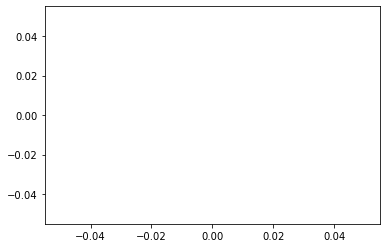

0.004
No old model data found, saving into new file
  11. training reward:  -8.74, loss: -0.0435
  21. training reward:  -7.96, loss: -0.1900
  31. training reward:  -7.50, loss: -0.2526
  41. training reward:  -5.64, loss: -0.5271
  51. training reward:  -7.12, loss: -0.2554
  61. training reward:  -5.72, loss: -0.4026
  71. training reward:  -6.76, loss: -0.3033
  81. training reward:  -6.22, loss: -0.5151
  91. training reward:  -5.30, loss: -0.3672
 101. training reward:  -8.44, loss: -0.1901


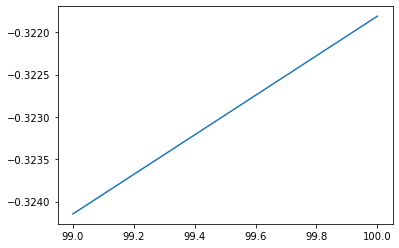

 111. training reward:  -8.08, loss: -0.1794
 121. training reward:  -7.00, loss: -0.4582
 131. training reward:  -8.70, loss:  0.0014
 141. training reward:  -7.10, loss: -0.3657
 151. training reward:  -5.82, loss: -0.6322
 161. training reward:  -8.02, loss: -0.1179
 171. training reward:  -8.16, loss: -0.2308
 181. training reward:  -7.30, loss: -0.3611
 191. training reward:  -5.93, loss: -0.6048
 201. training reward:  -7.52, loss: -0.3881


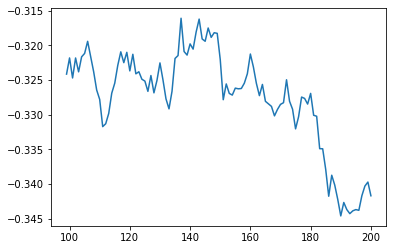

 211. training reward:  -5.86, loss: -0.5879
 221. training reward:  -7.52, loss: -0.2873
 231. training reward:  -7.40, loss: -0.2388
 241. training reward:  -7.18, loss: -0.3641
 251. training reward:  -7.46, loss: -0.3502
 261. training reward:  -7.38, loss: -0.2285
 271. training reward:  -8.08, loss: -0.2261
 281. training reward:  -6.28, loss: -0.4625
 291. training reward:  -8.88, loss: -0.0778
 301. training reward:  -8.10, loss: -0.2281


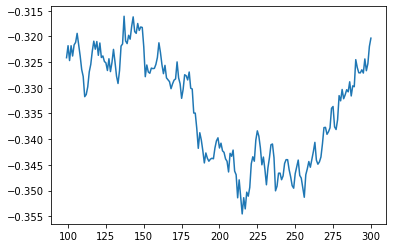

 311. training reward:  -7.52, loss: -0.1942
 321. training reward:  -7.20, loss: -0.2154
 331. training reward:  -6.60, loss: -0.4024
 341. training reward:  -5.66, loss: -0.5656
 351. training reward:  -5.70, loss: -0.6036
 361. training reward:  -7.88, loss: -0.0965
 371. training reward:  -6.54, loss: -0.2445
 381. training reward:  -6.76, loss: -0.3369
 391. training reward:  -7.36, loss: -0.5011
 401. training reward:  -5.86, loss: -0.2956


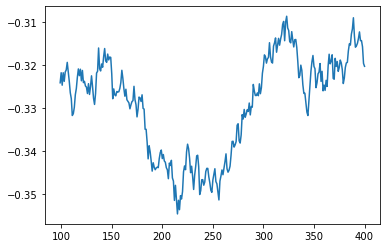

0.003
 411. training reward:  -7.36, loss: -0.1066
 421. training reward:  -9.00, loss: -0.0005
 431. training reward:  -7.56, loss: -0.1316
 441. training reward:  -6.26, loss: -0.5115
 451. training reward:  -7.50, loss: -0.3105
 461. training reward:  -8.10, loss: -0.1790
 471. training reward:  -6.74, loss: -0.2727
 481. training reward:  -7.38, loss: -0.2903
 491. training reward:  -7.62, loss: -0.2685
 501. training reward:  -6.72, loss: -0.3247


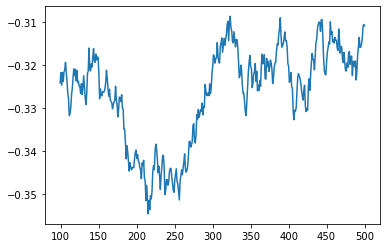

 511. training reward:  -6.36, loss: -0.3711
 521. training reward:  -5.02, loss: -0.6164
 531. training reward:  -4.86, loss: -0.5124
 541. training reward:  -5.52, loss: -0.4046
 551. training reward:  -6.72, loss: -0.2473
 561. training reward:  -8.26, loss: -0.2472
 571. training reward:  -5.70, loss: -0.5606
 581. training reward:  -8.08, loss: -0.3296
 591. training reward:  -7.72, loss: -0.1847
 601. training reward:  -5.50, loss: -0.3269


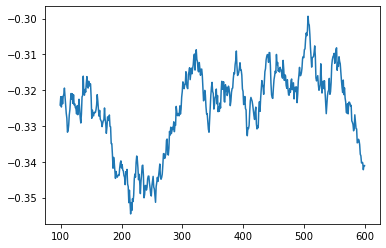

 611. training reward:  -7.76, loss: -0.3723
 621. training reward:  -6.14, loss: -0.3311
 631. training reward:  -8.82, loss: -0.1629
 641. training reward:  -6.62, loss: -0.3764
 651. training reward:  -5.40, loss: -0.5431
 661. training reward:  -7.68, loss: -0.2517
 671. training reward:  -6.52, loss: -0.4921
 681. training reward:  -6.36, loss: -0.3349
 691. training reward:  -6.50, loss: -0.5352
 701. training reward:  -8.52, loss: -0.0685


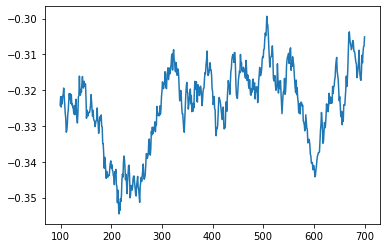

 711. training reward:  -7.50, loss: -0.2265
 721. training reward:  -5.57, loss: -0.4862
 731. training reward:  -6.28, loss: -0.4662
 741. training reward:  -6.86, loss: -0.1638
 751. training reward:  -6.52, loss: -0.3739
 761. training reward:  -7.74, loss: -0.2047
 771. training reward:  -9.00, loss: -0.0030
 781. training reward:  -8.83, loss: -0.0038
 791. training reward:  -8.70, loss: -0.0439
 801. training reward:  -7.48, loss: -0.3106


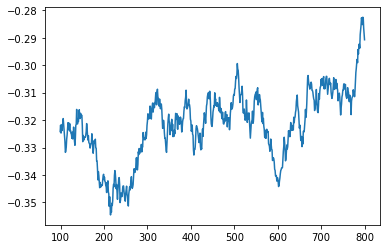

0.001
 811. training reward:  -7.72, loss: -0.2284
 821. training reward:  -5.45, loss: -0.5217
 831. training reward:  -5.70, loss: -0.3708
 841. training reward:  -4.33, loss: -0.5864
 851. training reward:  -8.32, loss: -0.3628
 861. training reward:  -7.10, loss: -0.3513
 871. training reward:  -4.83, loss: -0.5538
 881. training reward:  -7.34, loss: -0.3802
 891. training reward:  -6.94, loss: -0.3339
 901. training reward:  -7.54, loss: -0.2970


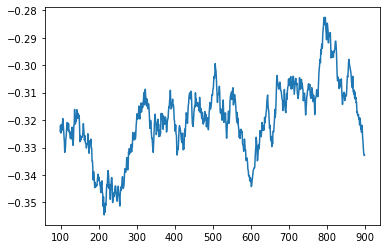

 911. training reward:  -7.32, loss: -0.3111
 921. training reward:  -8.80, loss: -0.0195
 931. training reward:  -6.54, loss: -0.5188
 941. training reward:  -7.58, loss: -0.3120
 951. training reward:  -6.22, loss: -0.4827
 961. training reward:  -7.12, loss: -0.4412
 971. training reward:  -5.65, loss: -0.5336
 981. training reward:  -6.34, loss: -0.4150
 991. training reward:  -7.48, loss: -0.2532
1001. training reward:  -5.77, loss: -0.5343


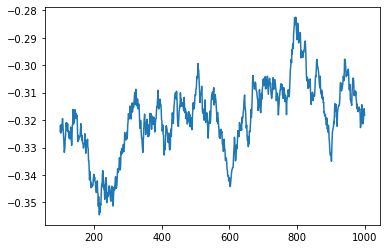

1011. training reward:  -7.04, loss: -0.3835
1021. training reward:  -5.43, loss: -0.5817
1031. training reward:  -8.00, loss: -0.2984
1041. training reward:  -6.00, loss: -0.5095
1051. training reward:  -5.62, loss: -0.5239
1061. training reward:  -6.96, loss: -0.2945
1071. training reward:  -7.10, loss: -0.2146
1081. training reward:  -5.96, loss: -0.4204
1091. training reward:  -6.32, loss: -0.4330
1101. training reward:  -7.10, loss: -0.2882


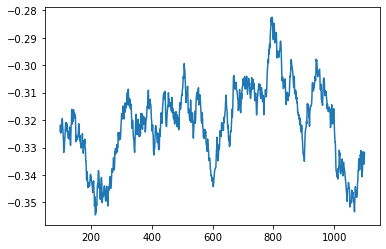

1111. training reward:  -5.05, loss: -0.5634
1121. training reward:  -6.90, loss: -0.4342
1131. training reward:  -6.60, loss: -0.3198
1141. training reward:  -6.00, loss: -0.2841
1151. training reward:  -7.76, loss: -0.4709
1161. training reward:  -7.64, loss: -0.0953
1171. training reward:  -7.46, loss: -0.4612
1181. training reward:  -7.80, loss: -0.1992
1191. training reward:  -6.58, loss: -0.3834
1201. training reward:  -7.90, loss: -0.1302


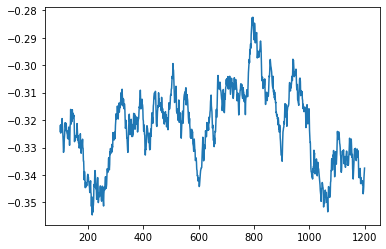

0.0
1211. training reward:  -7.16, loss: -0.3141
1221. training reward:  -7.30, loss: -0.2894
1231. training reward:  -7.22, loss: -0.4249
1241. training reward:  -7.68, loss: -0.2112
1251. training reward:  -5.88, loss: -0.3999
1261. training reward:  -6.54, loss: -0.3172
1271. training reward:  -7.58, loss: -0.1428
1281. training reward:  -7.08, loss: -0.2092
1291. training reward:  -8.85, loss: -0.0001
1301. training reward:  -5.77, loss: -0.4865


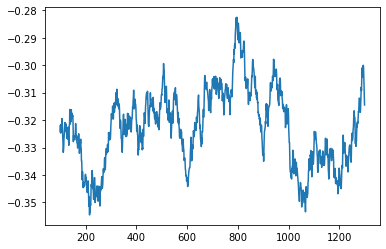

1311. training reward:  -7.02, loss: -0.2245
1321. training reward:  -5.47, loss: -0.4196
1331. training reward:  -8.60, loss: -0.0022
1341. training reward:  -8.20, loss: -0.2642
1351. training reward:  -6.46, loss: -0.4313
1361. training reward:  -6.88, loss: -0.3975
1371. training reward:  -7.04, loss: -0.4681
1381. training reward:  -7.88, loss: -0.3031
1391. training reward:  -8.85, loss: -0.0014
1401. training reward:  -7.56, loss: -0.3616


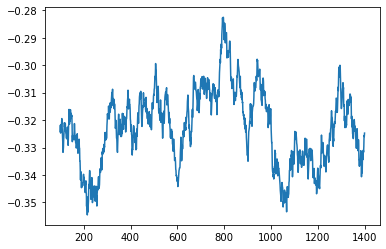

1411. training reward:  -8.96, loss: -0.0635
1421. training reward:  -7.84, loss: -0.2238
1431. training reward:  -7.90, loss: -0.2654
1441. training reward:  -6.42, loss: -0.3653
1451. training reward:  -5.98, loss: -0.4226
1461. training reward:  -5.92, loss: -0.5381
1471. training reward:  -4.97, loss: -0.4799
1481. training reward:  -6.00, loss: -0.5171
1491. training reward:  -5.76, loss: -0.5950
1501. training reward:  -6.40, loss: -0.5027


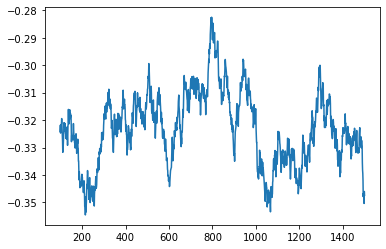

1511. training reward:  -6.64, loss: -0.4000
1521. training reward:  -7.20, loss: -0.4635
1531. training reward:  -8.48, loss: -0.0668
1541. training reward:  -6.36, loss: -0.2267
1551. training reward:  -4.13, loss: -0.5285
1561. training reward:  -7.14, loss: -0.2979
1571. training reward:  -7.56, loss: -0.3494
1581. training reward:  -6.78, loss: -0.4588
1591. training reward:  -5.52, loss: -0.3798
1601. training reward:  -7.58, loss: -0.4289


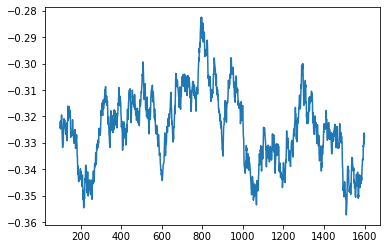

0.003
1611. training reward:  -4.70, loss: -0.5645
1621. training reward:  -8.24, loss: -0.1946
1631. training reward:  -6.96, loss: -0.3157
1641. training reward:  -6.52, loss: -0.3025
1651. training reward:  -8.58, loss: -0.1283
1661. training reward:  -5.33, loss: -0.4692
1671. training reward:  -7.32, loss: -0.2475
1681. training reward:  -5.96, loss: -0.5206
1691. training reward:  -8.16, loss: -0.2564
1701. training reward:  -5.37, loss: -0.7028


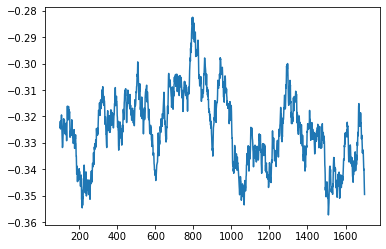

1711. training reward:  -6.42, loss: -0.4767
1721. training reward:  -6.76, loss: -0.3470
1731. training reward:  -8.70, loss: -0.0693
1741. training reward:  -6.92, loss: -0.4554
1751. training reward:  -6.70, loss: -0.4776
1761. training reward:  -3.62, loss: -0.3967
1771. training reward:  -7.50, loss: -0.2431
1781. training reward:  -8.80, loss: -0.0011
1791. training reward:  -7.46, loss: -0.2750
1801. training reward:  -8.92, loss: -0.1567


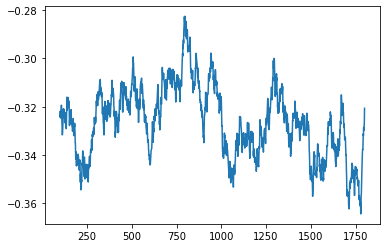

1811. training reward:  -7.06, loss: -0.4091
1821. training reward:  -7.36, loss: -0.2188
1831. training reward:  -7.88, loss: -0.2022
1841. training reward:  -5.74, loss: -0.4941
1851. training reward:  -6.36, loss: -0.5104
1861. training reward:  -5.80, loss: -0.4090
1871. training reward:  -8.04, loss: -0.1094
1881. training reward:  -5.53, loss: -0.4974
1891. training reward:  -6.86, loss: -0.4020
1901. training reward:  -7.08, loss: -0.1936


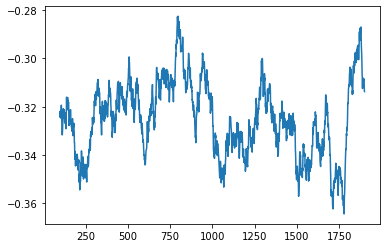

1911. training reward:  -7.42, loss: -0.4097
1921. training reward:  -7.72, loss: -0.0716
1931. training reward:  -5.20, loss: -0.5772
1941. training reward:  -8.56, loss: -0.1894
1951. training reward:  -5.40, loss: -0.3439
1961. training reward:  -7.98, loss: -0.0779
1971. training reward:  -6.32, loss: -0.3859
1981. training reward:  -7.14, loss: -0.2492
1991. training reward:  -6.68, loss: -0.3744
2001. training reward:  -7.04, loss: -0.3914


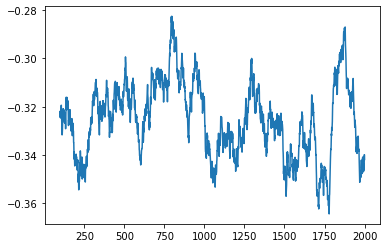

0.003
2011. training reward:  -6.30, loss: -0.5238
2021. training reward:  -6.50, loss: -0.2770
2031. training reward:  -7.90, loss: -0.3135
2041. training reward:  -7.84, loss: -0.1791
2051. training reward:  -5.94, loss: -0.4118
2061. training reward:  -5.96, loss: -0.5244
2071. training reward:  -6.94, loss: -0.3377
2081. training reward:  -7.48, loss: -0.4371
2091. training reward:  -6.44, loss: -0.3118
2101. training reward:  -6.84, loss: -0.2847


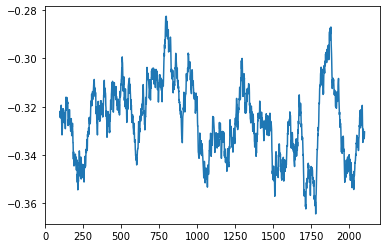

2111. training reward:  -8.88, loss: -0.0010
2121. training reward:  -6.42, loss: -0.5512
2131. training reward:  -4.72, loss: -0.4259
2141. training reward:  -9.35, loss: -0.0029
2151. training reward:  -5.87, loss: -0.5449
2161. training reward:  -8.52, loss: -0.1841
2171. training reward:  -7.76, loss: -0.1388
2181. training reward:  -4.42, loss: -0.6701
2191. training reward:  -6.92, loss: -0.2613
2201. training reward:  -5.72, loss: -0.4880


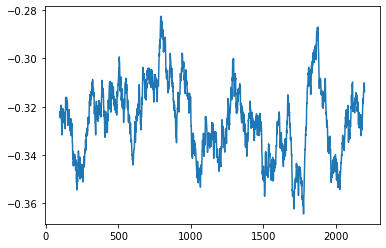

2211. training reward:  -8.48, loss: -0.1284
2221. training reward:  -7.20, loss: -0.3684
2231. training reward:  -7.34, loss: -0.4271
2241. training reward:  -7.02, loss: -0.3551
2251. training reward:  -6.74, loss: -0.3921
2261. training reward:  -7.10, loss: -0.3577
2271. training reward:  -7.26, loss: -0.3566
2281. training reward:  -7.38, loss: -0.2216
2291. training reward:  -6.06, loss: -0.4586
2301. training reward:  -5.66, loss: -0.4488


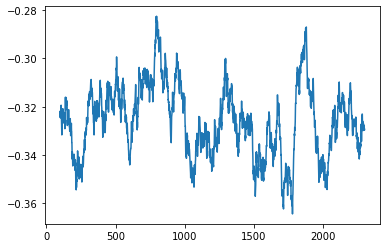

2311. training reward:  -5.70, loss: -0.3963
2321. training reward:  -7.48, loss: -0.2036
2331. training reward:  -8.65, loss: -0.0021
2341. training reward:  -7.70, loss: -0.2399
2351. training reward:  -8.20, loss: -0.2026
2361. training reward:  -8.08, loss: -0.1064
2371. training reward:  -6.96, loss: -0.3962
2381. training reward:  -6.72, loss: -0.4581
2391. training reward:  -6.48, loss: -0.5112
2401. training reward:  -8.16, loss: -0.0737


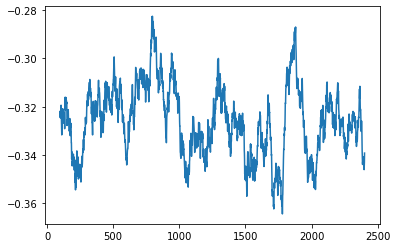

0.01
2411. training reward:  -8.24, loss: -0.1397
2421. training reward:  -6.50, loss: -0.4188
2431. training reward:  -6.66, loss: -0.4639
2441. training reward:  -6.22, loss: -0.6258
2451. training reward:  -6.54, loss: -0.5147
2461. training reward:  -7.82, loss: -0.2767
2471. training reward:  -9.20, loss: -0.0036
2481. training reward:  -5.24, loss: -0.5112
2491. training reward:  -5.74, loss: -0.5103
2501. training reward:  -5.82, loss: -0.4224


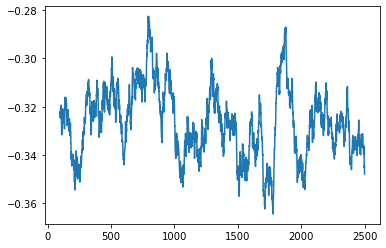

2511. training reward:  -6.52, loss: -0.2485
2521. training reward:  -7.10, loss: -0.5576
2531. training reward:  -5.96, loss: -0.4588
2541. training reward:  -7.72, loss: -0.2389
2551. training reward:  -6.04, loss: -0.4331
2561. training reward:  -6.22, loss: -0.4395
2571. training reward:  -8.66, loss: -0.0282
2581. training reward:  -5.78, loss: -0.3231
2591. training reward:  -6.32, loss: -0.4486
2601. training reward:  -6.96, loss: -0.3194


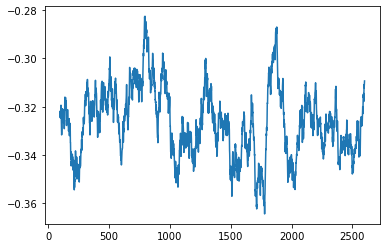

2611. training reward:  -7.46, loss: -0.1483
2621. training reward:  -8.08, loss: -0.1672
2631. training reward:  -6.42, loss: -0.3535
2641. training reward:  -4.02, loss: -0.4356
2651. training reward:  -6.86, loss: -0.2661
2661. training reward:  -5.28, loss: -0.5834
2671. training reward:  -8.28, loss: -0.0740
2681. training reward:  -7.36, loss: -0.3127
2691. training reward:  -6.82, loss: -0.3283
2701. training reward:  -5.78, loss: -0.5115


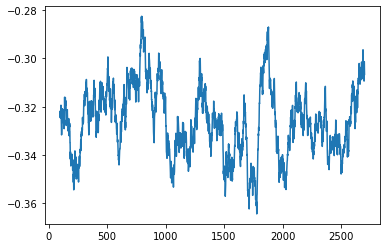

2711. training reward:  -8.18, loss: -0.2493
2721. training reward:  -8.38, loss: -0.1185
2731. training reward:  -9.08, loss: -0.0308
2741. training reward:  -6.66, loss: -0.5271
2751. training reward:  -7.72, loss: -0.2808
2761. training reward:  -6.38, loss: -0.4405
2771. training reward:  -6.32, loss: -0.2879
2781. training reward:  -6.94, loss: -0.3225
2791. training reward:  -6.30, loss: -0.3915
2801. training reward:  -7.06, loss: -0.3075


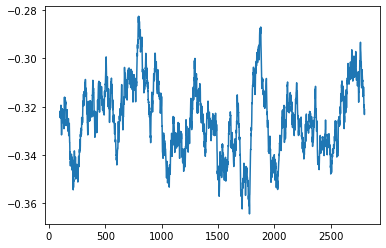

0.002
2811. training reward:  -5.33, loss: -0.5363
2821. training reward:  -7.94, loss: -0.2686
2831. training reward:  -7.72, loss: -0.2196
2841. training reward:  -6.44, loss: -0.5582
2851. training reward:  -6.90, loss: -0.2739
2861. training reward:  -7.82, loss: -0.2196
2871. training reward:  -7.06, loss: -0.2878
2881. training reward:  -8.38, loss: -0.2659
2891. training reward:  -7.30, loss: -0.2596
2901. training reward:  -7.10, loss: -0.4123


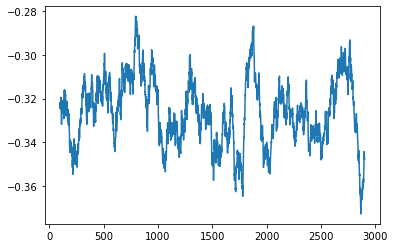

2911. training reward:  -7.94, loss: -0.2027
2921. training reward:  -8.02, loss: -0.2180
2931. training reward:  -8.30, loss: -0.1401
2941. training reward:  -7.86, loss: -0.1442
2951. training reward:  -6.02, loss: -0.4353
2961. training reward:  -7.72, loss: -0.3434
2971. training reward:  -6.86, loss: -0.3025
2981. training reward:  -6.08, loss: -0.5558
2991. training reward:  -7.86, loss: -0.1685
3001. training reward:  -7.46, loss: -0.2821


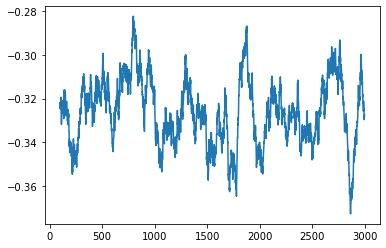

3011. training reward:  -6.10, loss: -0.5140
3021. training reward:  -7.50, loss: -0.2065
3031. training reward:  -6.92, loss: -0.3261
3041. training reward:  -6.02, loss: -0.5259
3051. training reward:  -4.52, loss: -0.5007
3061. training reward:  -4.85, loss: -0.5264
3071. training reward:  -5.82, loss: -0.3990
3081. training reward:  -7.60, loss: -0.2823
3091. training reward:  -7.68, loss: -0.2555
3101. training reward:  -6.22, loss: -0.4876


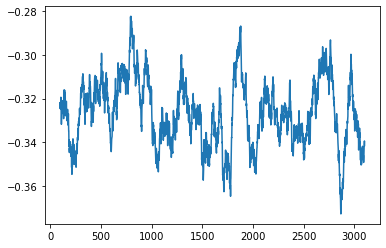

3111. training reward:  -7.00, loss: -0.2928
3121. training reward:  -6.88, loss: -0.2513
3131. training reward:  -6.48, loss: -0.3401
3141. training reward:  -5.60, loss: -0.6240
3151. training reward:  -9.05, loss: -0.0046
3161. training reward:  -5.60, loss: -0.5754
3171. training reward:  -6.36, loss: -0.4102
3181. training reward:  -8.55, loss: -0.0059
3191. training reward:  -8.90, loss: -0.0020
3201. training reward:  -7.32, loss: -0.2674


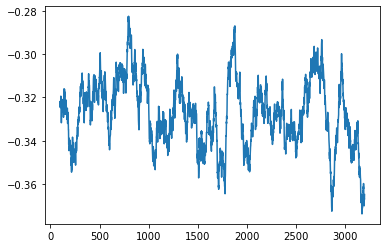

0.008
3211. training reward:  -8.00, loss: -0.0988
3221. training reward:  -6.44, loss: -0.4906
3231. training reward:  -8.14, loss: -0.1846
3241. training reward:  -6.52, loss: -0.4193
3251. training reward:  -5.52, loss: -0.4241
3261. training reward:  -4.58, loss: -0.5844
3271. training reward:  -4.72, loss: -0.7146
3281. training reward:  -5.10, loss: -0.7468
3291. training reward:  -6.42, loss: -0.4687
3301. training reward:  -5.24, loss: -0.3564


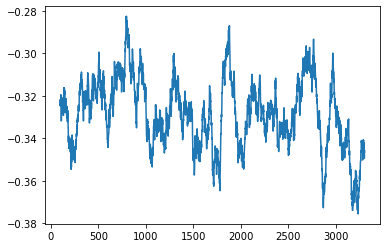

3311. training reward:  -7.44, loss: -0.2841
3321. training reward:  -6.18, loss: -0.4366
3331. training reward:  -5.56, loss: -0.4912
3341. training reward:  -7.38, loss: -0.2636
3351. training reward:  -7.94, loss: -0.1710
3361. training reward:  -6.22, loss: -0.5875
3371. training reward:  -5.15, loss: -0.1422
3381. training reward:  -7.86, loss: -0.2888
3391. training reward:  -6.74, loss: -0.2406
3401. training reward:  -6.14, loss: -0.5736


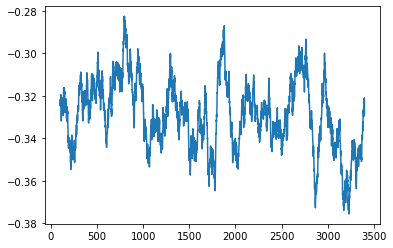

3411. training reward:  -6.56, loss: -0.3943
3421. training reward:  -6.60, loss: -0.4801
3431. training reward:  -5.70, loss: -0.5945
3441. training reward:  -6.60, loss: -0.3971
3451. training reward:  -8.90, loss: -0.0075
3461. training reward:  -5.88, loss: -0.4045
3471. training reward:  -7.12, loss: -0.2782
3481. training reward:  -7.84, loss: -0.2584
3491. training reward:  -6.66, loss: -0.4987
3501. training reward:  -7.78, loss: -0.1190


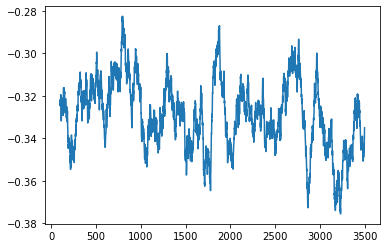

3511. training reward:  -7.16, loss: -0.2528
3521. training reward:  -8.16, loss: -0.1005
3531. training reward:  -4.88, loss: -0.4156
3541. training reward:  -6.20, loss: -0.4992
3551. training reward:  -6.92, loss: -0.4202
3561. training reward:  -5.75, loss: -0.5203
3571. training reward:  -8.48, loss: -0.1472
3581. training reward:  -6.66, loss: -0.4153
3591. training reward:  -5.38, loss: -0.4822
3601. training reward:  -7.14, loss: -0.3817


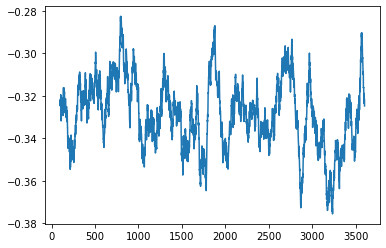

0.006
3611. training reward:  -7.04, loss: -0.3029
3621. training reward:  -5.08, loss: -0.4348
3631. training reward:  -9.28, loss: -0.0745
3641. training reward:  -7.02, loss: -0.3898
3651. training reward:  -4.94, loss: -0.3379
3661. training reward:  -7.14, loss: -0.3970
3671. training reward:  -4.55, loss: -0.7237
3681. training reward:  -5.78, loss: -0.4110
3691. training reward:  -7.48, loss: -0.3706
3701. training reward:  -8.75, loss: -0.0061


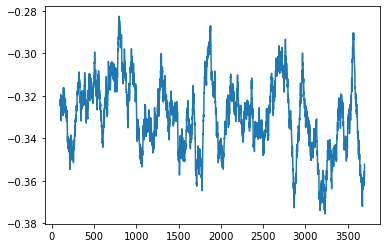

3711. training reward:  -5.30, loss: -0.5083
3721. training reward:  -8.22, loss: -0.0396
3731. training reward:  -6.64, loss: -0.2960
3741. training reward:  -6.72, loss: -0.3400
3751. training reward:  -4.92, loss: -0.4880
3761. training reward:  -6.05, loss: -0.4711
3771. training reward:  -7.36, loss: -0.3481
3781. training reward:  -8.24, loss: -0.1882
3791. training reward:  -8.14, loss: -0.2275
3801. training reward:  -8.10, loss: -0.1161


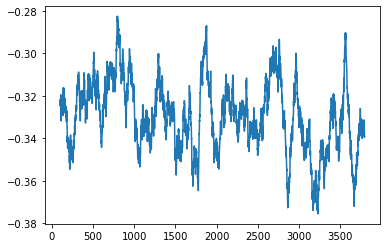

3811. training reward:  -5.60, loss: -0.5863
3821. training reward:  -6.30, loss: -0.4350
3831. training reward:  -5.42, loss: -0.4645
3841. training reward:  -8.74, loss: -0.1381
3851. training reward:  -7.10, loss: -0.3672
3861. training reward:  -5.44, loss: -0.5220
3871. training reward:  -6.76, loss: -0.2712
3881. training reward:  -6.06, loss: -0.5481
3891. training reward:  -8.40, loss: -0.0114
3901. training reward:  -5.36, loss: -0.4801


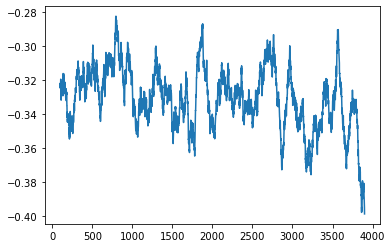

3911. training reward:  -5.86, loss: -0.5751
3921. training reward:  -7.08, loss: -0.3942
3931. training reward:  -7.58, loss: -0.2320
3941. training reward:  -5.78, loss: -0.6020
3951. training reward:  -6.14, loss: -0.3555
3961. training reward:  -8.44, loss: -0.1478
3971. training reward:  -6.76, loss: -0.4474
3981. training reward:  -6.42, loss: -0.4398
3991. training reward:  -5.78, loss: -0.4792
4001. training reward:  -4.82, loss: -0.7196


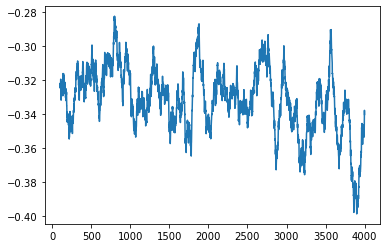

0.003
4011. training reward:  -6.82, loss: -0.3076
4021. training reward:  -5.66, loss: -0.4239
4031. training reward:  -5.88, loss: -0.5855
4041. training reward:  -8.06, loss: -0.2702
4051. training reward:  -6.10, loss: -0.4312
4061. training reward:  -8.36, loss: -0.1058
4071. training reward:  -7.38, loss: -0.2195
4081. training reward:  -5.38, loss: -0.4979
4091. training reward:  -6.36, loss: -0.4843
4101. training reward:  -5.76, loss: -0.4576


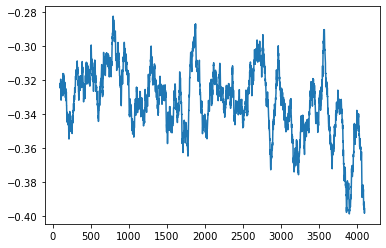

4111. training reward:  -6.86, loss: -0.3768
4121. training reward:  -6.86, loss: -0.3977
4131. training reward:  -5.90, loss: -0.5322
4141. training reward:  -6.00, loss: -0.3706
4151. training reward:  -6.18, loss: -0.3701
4161. training reward:  -6.02, loss: -0.3722
4171. training reward:  -6.50, loss: -0.4494
4181. training reward:  -7.72, loss: -0.2127
4191. training reward:  -6.80, loss: -0.4365
4201. training reward:  -7.82, loss: -0.3187


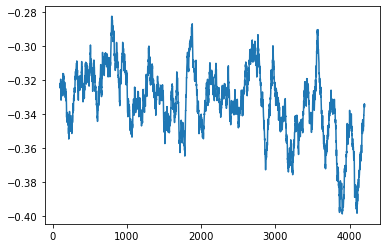

4211. training reward:  -7.32, loss: -0.3658
4221. training reward:  -9.12, loss: -0.0073
4231. training reward:  -5.36, loss: -0.4836
4241. training reward:  -7.12, loss: -0.3922
4251. training reward:  -7.06, loss: -0.3402
4261. training reward:  -6.42, loss: -0.5973
4271. training reward:  -7.56, loss: -0.3166
4281. training reward:  -7.38, loss: -0.3605
4291. training reward:  -5.30, loss: -0.4918
4301. training reward:  -6.68, loss: -0.4889


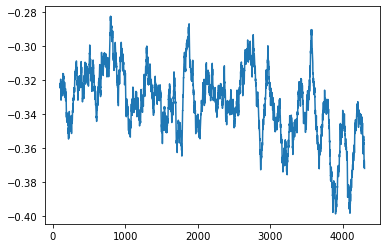

4311. training reward:  -8.08, loss: -0.1486
4321. training reward:  -6.00, loss: -0.1641
4331. training reward:  -8.10, loss: -0.2932
4341. training reward:  -5.18, loss: -0.5787
4351. training reward:  -5.64, loss: -0.6520
4361. training reward:  -6.48, loss: -0.4142
4371. training reward:  -7.54, loss: -0.4377
4381. training reward:  -6.76, loss: -0.3166
4391. training reward:  -7.26, loss: -0.3275
4401. training reward:  -6.28, loss: -0.4437


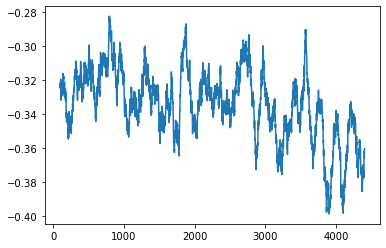

0.008
Saving Statistics
No old model data found, saving into new file


In [15]:
#Base code was written by Jonas Busk - Modified to suit project by Jacob Jon Hansen
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.nn import relu, softmax
import gym
import pickle
from sklearn.preprocessing import normalize
import pandas as pd
import random
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import sys
import os
sys.path.append('../')
# from minesweeper_tk import Minesweeper


model = "pg_custom_env_4x4"
new_model = "pg_custom_env_4x4"
# training settings

epochs = 500000 # number of training batches
batch_size = 200 # number of timesteps in a batch
rollout_limit = 50 # max rollout length
discount_factor = 0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.000002  # you know this by now #0.001, 
                                               #5600: 78% win --> LR: 0.0001
                                               #6801: 87% win --> LR: 0.00002
                                                
early_stop_loss = 0 # stop training if loss < early_stop_loss, 0 or False to disable

""" condensed
epochs = 100000 # number of training batches
batch_size = 400 # number of timesteps in a batch
rollout_limit = 50 # max rollout length
discount_factor = 0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.00004  # you know this by now #0.0005
early_stop_loss = 0 # stop training if loss < early_stop_loss, 0 or False to disable
"""

""" 261 epocs to learn 2 specific board (overfit)
epochs = 10000 # number of training batches
batch_size = 200 # number of timesteps in a batch
rollout_limit = 130 # max rollout length
discount_factor = 0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
early_stop_loss = 0 # stop training if loss < early_stop_loss, 0 or False to disable

"""


# setup policy network
n = 4
n_inputs = 4*4*2
n_hidden = 4*4*8
n_hidden2 = 220
n_hidden3 = 220
n_hidden4 = 220
n_outputs = 4*4

dropout = 0.25

tf.reset_default_graph()

states_pl = tf.placeholder(tf.float32, [None, n_inputs], name='states_pl')
actions_pl = tf.placeholder(tf.int32, [None, 2], name='actions_pl')
advantages_pl = tf.placeholder(tf.float32, [None], name='advantages_pl')
learning_rate_pl = tf.placeholder(tf.float32, name='learning_rate_pl')

input_layer = tf.reshape(states_pl, [-1, n, n, 2])
conv1 = tf.layers.conv2d(inputs=input_layer,filters=18,kernel_size=[5, 5],padding="same", activation=tf.nn.relu)
conv2 = tf.layers.conv2d(inputs=conv1,filters=36,kernel_size=[3, 3],padding="same", activation=tf.nn.relu)
conv2_flat = tf.layers.flatten(conv2)
l_hidden = tf.layers.dense(inputs=conv2_flat, units=n_hidden, activation=relu, name='l_hidden')
l_hidden2 = tf.layers.dense(inputs=l_hidden, units=n_hidden2, activation=relu, name='l_hidden2')
l_hidden3 = tf.layers.dense(inputs=l_hidden2, units=n_hidden3, activation=relu, name='l_hidden3')
l_out = tf.layers.dense(inputs=l_hidden3, units=n_outputs, activation=softmax, name='l_out')

# print network
print('states_pl:', states_pl.get_shape())
print('actions_pl:', actions_pl.get_shape())
print('advantages_pl:', advantages_pl.get_shape())
print('l_hidden:', l_hidden.get_shape())
print('l_hidden2:', l_hidden2.get_shape())
print('l_hidden3:', l_hidden3.get_shape())
print('l_out:', l_out.get_shape())

# define loss and optimizer
loss_f = -tf.reduce_mean(tf.multiply(tf.log(tf.gather_nd(l_out, actions_pl)), advantages_pl))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_pl, beta1=0.8, beta2=0.92)
train_f = optimizer.minimize(loss_f)

saver = tf.train.Saver() # we use this later to save the model

# test forward pass
env = MinesweeperEnv(4, 4, 1)
OUT = "CONDENSED"

state = stateConverter(OUT, get_state(env.state)).flatten()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    action_probabilities = sess.run(fetches=l_out, feed_dict={states_pl: [state]})
print(action_probabilities)

# helper functions

def get_rollout(sess, env, rollout_limit=None, stochastic=False, seed=None):
    """Generate rollout by iteratively evaluating the current policy on the environment."""
    rollout_limit = rollout_limit
    
    env.reset()
    s = stateConverter(OUT, get_state(env.state)).flatten()
    states, actions, rewards = [], [], []
    for i in range(rollout_limit):
        a = get_action(sess, s, stochastic)
        s1, r, done = env.step(a)
        s1 = stateConverter(OUT, get_state(env.state))
        s1 = s1.flatten()
        states.append(s)
        actions.append(a)
        rewards.append(r)
        s = s1
        if done: break
    return states, actions, rewards, i+1

def get_action(sess, state, stochastic=False):
    """Choose an action, given a state, with the current policy network."""
    a_prob = sess.run(fetches=l_out, feed_dict={states_pl: np.atleast_2d(state)})

    if stochastic:
        # sample action from distribution
        return (np.cumsum(np.asarray(a_prob)) > np.random.rand()).argmax()
    else:
        # select action with highest probability
        return a_prob.argmax()

def get_advantages(rewards, rollout_limit, discount_factor, eps=1e-12):
    """Compute advantages"""
    returns = get_returns(rewards, rollout_limit, discount_factor)
    # standardize columns of returns to get advantages
    advantages = (returns - np.mean(returns, axis=0)) / (np.std(returns, axis=0) + eps)
    # restore original rollout lengths
    advantages = [adv[:len(rewards[i])] for i, adv in enumerate(advantages)]
    return advantages

def get_returns(rewards, rollout_limit, discount_factor):
    """Compute the cumulative discounted rewards, a.k.a. returns."""
    returns = np.zeros((len(rewards), rollout_limit))
    for i, r in enumerate(rewards):
        returns[i, len(r) - 1] = r[-1]
        for j in reversed(range(len(r)-1)):
            returns[i,j] = r[j] + discount_factor * returns[i,j+1]
    return returns

def get_winrate(sess, env):
    games = 0
    moves = 0
    stuck = 0
    won_games = 0
    lost_games = 0
    r = 0
    while games < 1000:
        while True:
            s = stateConverter(OUT, get_state(env.state)).flatten()
            if r < 0: 
                a = get_action(sess, s, stochastic=True)
            else:
                a = get_action(sess, s, stochastic=False)
            moves += 1
            s, r, done= env.step(a)
            s = get_state(env.state)
            s = s.flatten()
            if r == 1:
                won_games += 1
            if r == 0:
                lost_games += 1

            if done:
                games += 1
                env.reset()
                moves = 0
                break
            elif moves >= 30:
                stuck += 1
                games += 1
                lost_games = lost_games + 1
                env.reset()
                moves = 0
                break
    return(won_games/games)

def smooth(y,factor):
    if type(y)!=list:
        y = list(y)
    return pd.Series(y).rolling(window=factor).mean()#[factor:]
# train policy network

try:
    statistics = []
    losses = []
    win_rate = 0
    win_rate_best = 0
    with tf.Session() as sess:

        #Load last model
        try:
            stats = pickle.load(open("{}/stats.p".format(model), "rb"))
            saver.restore(sess, "{}/{}.ckpt".format(model,model))
            epoch_start = stats[len(stats)-1][0]
            env.nb_actions = stats[len(stats)-1][1]
            win_rate = stats[len(stats)-1][4]
            win_rate_best = win_rate

        except:
            print("Couldn't find old model")
            sess.run(tf.global_variables_initializer())
            epoch_start = 0        

        for epoch in range(epoch_start, epochs):
            # generate rollouts until batch_size total timesteps are collected
            states, actions, rewards = [], [], []
            timesteps = 0
            while timesteps < batch_size:
                _rollout_limit = min(rollout_limit, batch_size - timesteps) # limit rollout to match batch_size
                s, a, r, t = get_rollout(sess, env, rollout_limit, stochastic=True, seed=epoch)     
                states.append(s)
                actions.append(a)
                rewards.append(r)
                timesteps += t
            # compute advantages
            advantages = get_advantages(rewards, rollout_limit, discount_factor)
            # policy gradient update
            loss, _ = sess.run(fetches=[loss_f, train_f], feed_dict={
                states_pl: np.concatenate(states),
                actions_pl: np.column_stack((np.arange(timesteps), np.concatenate(actions))),
                advantages_pl: np.concatenate(advantages),
                learning_rate_pl: learning_rate
            })            


            mtr = np.mean([np.sum(r) for r in rewards])
            statistics.append([epoch, env.n_clicks, mtr, loss, win_rate])
            losses.append(loss)
            if epoch % 10 == 0:
                print('%4d. training reward: %6.2f, loss: %7.4f' % (epoch+1, mtr, loss))
            
            if epoch % 100 == 0:    
                saver.save(sess, "{}/{}.ckpt".format(new_model,model))
                losses_smooth = smooth(losses, 100)
                plt.plot(losses_smooth)
                plt.show()

            if epoch % 400 == 0:
                #Get win-rate
                win_rate = get_winrate(sess, env)
                print(win_rate)

                if win_rate > win_rate_best:
                    saver.save(sess, "{}/{}_best.ckpt".format(new_model,model))
                
                # save session

                try: 
                    stats = pickle.load(open("{}/stats.p".format(new_model), "rb"))
                    for i in range(len(statistics)):
                        stats.append(statistics[i])
                    statistics = stats
                except:
                    print("No old model data found, saving into new file")

                pickle.dump(statistics, open("{}/stats.p".format(new_model), "wb"))

        print('done')

except KeyboardInterrupt:
    print('Saving Statistics')

    try: 
        stats = pickle.load(open("{}/stats.p".format(new_model), "rb"))
        for i in range(len(statistics)):
            stats.append(statistics[i])
        statistics = stats
    except:
        print("No old model data found, saving into new file")

    pickle.dump(statistics, open("{}/stats.p".format(new_model), "wb"))
